# Packages and function definitions

In [4]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

Package to perform wavelet transforms:

In [5]:
import pywt

Autocorrelation and autocovariance of a series of values:

In [6]:
def autocorr(X, max_d):
    ac = np.zeros(max_d)
    D = np.arange(max_d)
    ac[0] = 1.0
    for d in D[1:]:
        X1 = X[:-d]
        X2 = X[d:]
        ac[d] = np.nanmean(X1 * X2) - np.nanmean(X1)*np.nanmean(X2)
        ac[d] /= np.nanstd(X1)*np.nanstd(X2)
    return D, ac

def autocov(X, max_d):
    ac = np.zeros(max_d)
    D = np.arange(max_d)
    ac[0] = np.var(X)
    for d in D[1:]:
        X1 = X[:-d]
        X2 = X[d:]
        ac[d] = np.nanmean(X1 * X2) - np.nanmean(X1)*np.nanmean(X2)
    return D, ac

Variance-stabilizing Anscombe transform for Poisson data (and its inverse):

In [7]:
def anscombe_transform(X):
    return 2.0*np.sqrt(X)
def anscombe_transform_inverse(X):
    return (X/2.0)**2

Perform soft-thresholding with threshold t on a list of wavelet coefficients:

In [8]:
def denoise_wavelets(wavelet_coeffs, t=1.0):
    return [np.sign(wc)*np.maximum(0, np.abs(wc) - t) for wc in wavelet_coeffs]

# Comeron et al. recombination rate data

Comeron et al. (PloS Genet., 2012) estimated the recombination rate of Drosophila melanogaster in 100Kb windows along the genome using 5,860 female meioses. We'd like to use these estimates to see how signals of MMC vary with recombination rate. But first, we'll take a look at it.

Let's start with just the chr2L chromosome arm.

In [11]:
data_dir = "../data/recombination_maps/Comeron_tables/"
chr2L = np.loadtxt(data_dir + 'Comeron_100kb_chr2L.txt')

In [12]:
print(chr2L.shape)
print(chr2L[:10,:])

(231, 2)
[[  1.00000000e+00   0.00000000e+00]
 [  1.00001000e+05   0.00000000e+00]
 [  2.00001000e+05   0.00000000e+00]
 [  3.00001000e+05   2.34550139e-01]
 [  4.00001000e+05   2.34550139e-01]
 [  5.00001000e+05   1.99367618e+00]
 [  6.00001000e+05   1.40730083e+00]
 [  7.00001000e+05   1.05547562e+00]
 [  8.00001000e+05   2.34550139e+00]
 [  9.00001000e+05   3.04915180e+00]]


First, let's confirm that the data is in fact in 100Kb windows and check out the mean recombination rate.

In [188]:
w_start = chr2L[:,0]
w_size = w_start[1]-w_start[0]
print("Data is in {} bp windows.".format(int(w_size)))
recomb = chr2L[:,1]

Data is in 100000 bp windows.


In [189]:
print("Mean recombination rate = {:.2f} cM/Mb".format(np.mean(recomb)))
print("Std. recombination rate= {:.2f} cM/Mb".format(np.std(recomb)))

Mean recombination rate = 2.40 cM/Mb
Std. recombination rate= 2.09 cM/Mb


This checks out, so we'll go on to plot the recombination rate as a function of genomic position, as in Figure 1 of the paper.

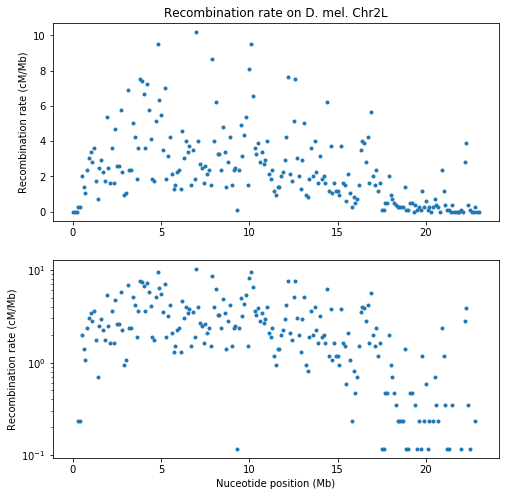

In [95]:
fig = plt.figure(figsize=(8,8))
ax1 = plt.subplot(211)
ax1.plot(w_start/1e6, recomb, '.')
ax1.set_ylabel('Recombination rate (cM/Mb)')
ax1.set_title(r'Recombination rate on D. mel. Chr2L')
ax2 = plt.subplot(212)
ax2.semilogy(w_start/1e6, recomb, '.')
ax2.set_ylabel('Recombination rate (cM/Mb)')
ax2.set_xlabel('Nuceotide position (Mb)')
plt.show()

The top panel (linear scale) indeed matches Figure 1a. The bottom panel (log scale) shows that there is ~10-fold variation among the windows, which agrees with the claims of the paper.

It's clear that much of the variation is uncorrelated from window to the next. We can formalize this by looking at the autocovariance function:

In [191]:
max_d = int(1e7/w_size)
D, ac = autocov(recomb, max_d)

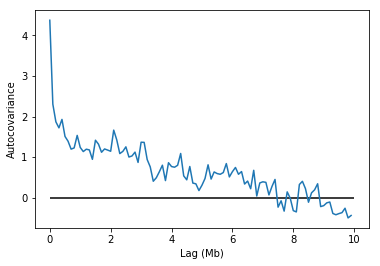

In [192]:
plt.plot(D*w_size/1e6,ac, '-')
plt.hlines(0, 0, 10)
plt.xlabel('Lag (Mb)')
plt.ylabel('Autocovariance')
plt.show()

In [20]:
print(ac[1]/ac[0])

0.527043896866


There is clearly a large "nugget" in the language of spatial modeling: the lag-1 covariance is only half of the "lag-0" variance.  This can mean one of two things. Either the variation among windows is dominated by measurement noise, or there is large spatial variation in recombination rate at a scale much less than 100Kb. We'd like to reduce the effects of the former, while preserving the latter if it exists. The rest of this notebook is dedicated to exploring a method for how to do this.

# Rescaling to counts

The reported recombination rates were estimated by counting the number of recombination rates observed in each window across a ~6k meiosis events. If we can transform the data back to counts, we can then model the counting noise as a Poisson process. This model will allow us to separate the measurement noise from "true" variation in recombination rates.

If the reported recombination rates are in fact linearly-transformed counts, we expect to see discrete levels. That is, all windows should have recombination rates that are integer multiples of some value.

First, we find the smallest non-zero value in the dataset:

In [193]:
print(w_start[recomb==0])

[  1.00000000e+00   1.00001000e+05   2.00001000e+05   1.93000010e+07
   2.03000010e+07   2.08000010e+07   2.14000010e+07   2.16000010e+07
   2.17000010e+07   2.18000010e+07   2.19000010e+07   2.21000010e+07
   2.26000010e+07   2.27000010e+07   2.29000010e+07   2.30000010e+07]


In [195]:
min_r = min(recomb[recomb>0])
print(min_r)

0.117275069


Looking at the smallest 40 non-zero values, it appears that all are integer multiples of min_r:

In [23]:
print(np.sort(recomb[recomb>0])[:40])

[ 0.11727507  0.11727507  0.11727507  0.11727507  0.11727507  0.11727507
  0.11727507  0.11727507  0.11727507  0.11727507  0.11727507  0.11727507
  0.23455014  0.23455014  0.23455014  0.23455014  0.23455014  0.23455014
  0.23455014  0.23455014  0.23455014  0.23455014  0.23455014  0.23455014
  0.23455014  0.35182521  0.35182521  0.35182521  0.35182521  0.35182521
  0.35182521  0.46910028  0.46910028  0.46910028  0.46910028  0.46910028
  0.46910028  0.58637535  0.58637535  0.70365042]


Now, let's rescale the recombination rates by min_r to get the underlying counts. We'll also check that the remainders are on the scale of machine error.

In [24]:
remainder, recomb_norm = np.modf(recomb / min_r)

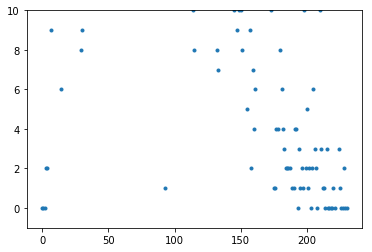

In [25]:
plt.plot(recomb_norm,'.')
plt.ylim([-1,10])
plt.show()

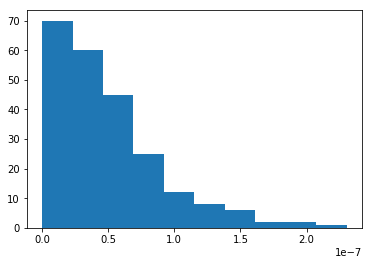

In [26]:
plt.hist(remainder)
plt.show()

The errors are all ~1e-7, so it looks like the data are in fact discrete.

In principle, 1/min_r should be related to the number of samples, 5860. But it doesn't appear to be:

In [27]:
print(1.0/min_r)

8.52696151473


In [198]:
print(1.0/5860*1000)

0.17064846416382254


We should at some point try to figure out how the authors got from their raw counts to the reported recombination rate.

# Variance stabilization with the Anscombe transform

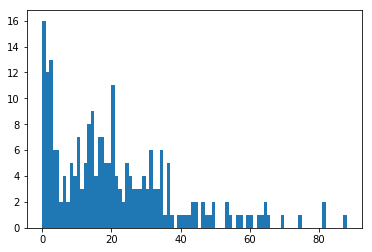

In [199]:
plt.hist(recomb_norm, bins=np.arange(np.max(recomb_norm)+2))
plt.show()

In [200]:
print('Lambda\tVar(X)\tVar(Y)\tansc_inv(Mean(Y))')
for lam in range(21):
    X = np.random.poisson(lam=lam, size=100000)
    Y = anscombe_transform(X)
    print('{:d}\t{:.2f}\t{:.2f}\t{:.2f}'.format(lam, np.var(X), np.var(Y), anscombe_transform_inverse(np.mean(Y))))

Lambda	Var(X)	Var(Y)	ansc_inv(Mean(Y))
0	0.00	0.00	0.00
1	1.01	1.61	0.60
2	2.00	1.56	1.61
3	3.02	1.35	2.67
4	4.02	1.22	3.69
5	5.03	1.15	4.71
6	5.98	1.10	5.72
7	7.05	1.08	6.72
8	7.97	1.06	7.74
9	8.98	1.05	8.76
10	10.07	1.05	9.75
11	10.97	1.04	10.73
12	11.91	1.03	11.75
13	13.05	1.04	12.74
14	14.02	1.03	13.74
15	15.01	1.03	14.75
16	15.93	1.02	15.74
17	16.98	1.02	16.74
18	18.01	1.02	17.76
19	18.80	1.01	18.75
20	19.94	1.02	19.73


In [201]:
recomb_ansc = anscombe_transform(recomb_norm)

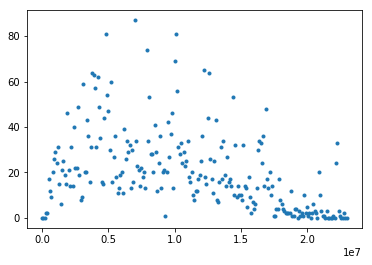

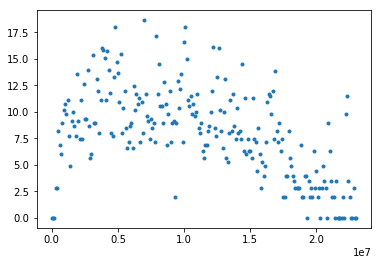

In [202]:
plt.plot(w_start, recomb_norm, '.')
plt.show()
plt.plot(w_start, recomb_ansc, '.')
plt.show()

# Wavelet denoising

In [234]:
pywt.wavelist(kind='discrete')

['bior1.1',
 'bior1.3',
 'bior1.5',
 'bior2.2',
 'bior2.4',
 'bior2.6',
 'bior2.8',
 'bior3.1',
 'bior3.3',
 'bior3.5',
 'bior3.7',
 'bior3.9',
 'bior4.4',
 'bior5.5',
 'bior6.8',
 'coif1',
 'coif2',
 'coif3',
 'coif4',
 'coif5',
 'coif6',
 'coif7',
 'coif8',
 'coif9',
 'coif10',
 'coif11',
 'coif12',
 'coif13',
 'coif14',
 'coif15',
 'coif16',
 'coif17',
 'db1',
 'db2',
 'db3',
 'db4',
 'db5',
 'db6',
 'db7',
 'db8',
 'db9',
 'db10',
 'db11',
 'db12',
 'db13',
 'db14',
 'db15',
 'db16',
 'db17',
 'db18',
 'db19',
 'db20',
 'db21',
 'db22',
 'db23',
 'db24',
 'db25',
 'db26',
 'db27',
 'db28',
 'db29',
 'db30',
 'db31',
 'db32',
 'db33',
 'db34',
 'db35',
 'db36',
 'db37',
 'db38',
 'dmey',
 'haar',
 'rbio1.1',
 'rbio1.3',
 'rbio1.5',
 'rbio2.2',
 'rbio2.4',
 'rbio2.6',
 'rbio2.8',
 'rbio3.1',
 'rbio3.3',
 'rbio3.5',
 'rbio3.7',
 'rbio3.9',
 'rbio4.4',
 'rbio5.5',
 'rbio6.8',
 'sym2',
 'sym3',
 'sym4',
 'sym5',
 'sym6',
 'sym7',
 'sym8',
 'sym9',
 'sym10',
 'sym11',
 'sym12',
 'sym13',

In [242]:
wavelet = 'db1'
extension_mode = 'constant'
threshold = 2.0

In [243]:
wavelet_coeffs = pywt.wavedec(recomb_ansc, wavelet, extension_mode)

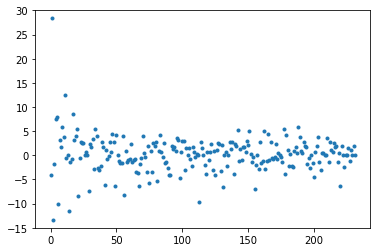

In [244]:
plt.plot(pywt.coeffs_to_array(wavelet_coeffs)[0][2:],'.')
plt.ylim([-15,30])
plt.show()

In [245]:
wavelet_coeffs_smoothed = denoise_wavelets(wavelet_coeffs, t=threshold)

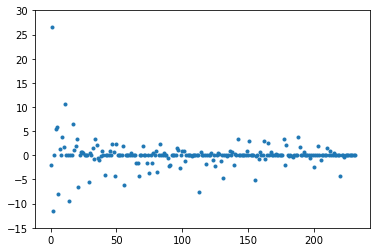

In [246]:
plt.plot(pywt.coeffs_to_array(wavelet_coeffs_smoothed)[0][2:],'.')
plt.ylim([-15,30])
plt.show()

In [247]:
inverse = pywt.waverec(wavelet_coeffs_smoothed, wavelet, extension_mode)[:-1]
recomb_smoothed = anscombe_transform_inverse(inverse)*min_r

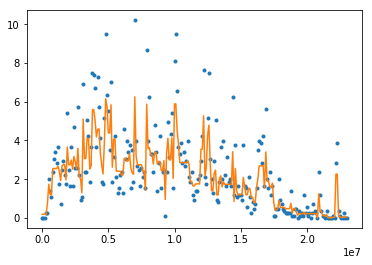

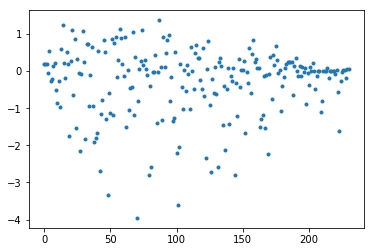

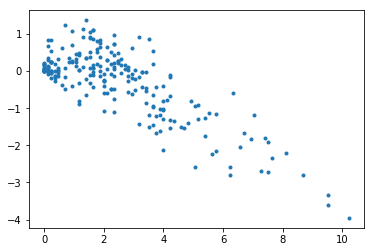

In [248]:
plt.plot(w_start, recomb, '.')
plt.plot(w_start, recomb_smoothed, '-')
plt.show()
plt.plot(recomb_smoothed - recomb,'.')
plt.show()
plt.plot(recomb, recomb_smoothed - recomb,'.')
plt.show()

In [91]:
D_raw, ac_raw = autocorr(recomb, int(1e7/w_size))
D_smooth, ac_smooth = autocorr(recomb_smoothed, int(1e7/w_size))

In [92]:
D_raw, ac_raw = autocov(recomb, int(1e7/w_size))
D_smooth, ac_smooth = autocov(recomb_smoothed, int(1e7/w_size))

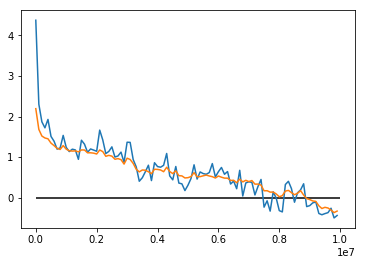

In [93]:
plt.plot(D_raw*w_size, ac_raw)
plt.plot(D_smooth*w_size, ac_smooth)
plt.hlines(0,0,1e7)
plt.show()

# Poisson simulation

In [175]:
lam_med = np.median(recomb_norm)
print(lam_med)

17.0


In [176]:
poisson_counts = np.random.poisson(lam_med, len(recomb_norm))
poisson_ansc = anscombe_transform(poisson_counts)
poisson_wave = pywt.wavedec(poisson_ansc, wavelet, extension_mode)
poisson_wave_smoothed = denoise_wavelets(poisson_wave, t=2.0)
poisson_inv = pywt.waverec(poisson_wave_smoothed, wavelet, extension_mode)
if len(poisson_inv) > len(poisson_counts):
    poisson_inv = poisson_inv[:-(len(poisson_inv)-len(poisson_counts))]
poisson_smoothed = anscombe_transform_inverse(poisson_inv)

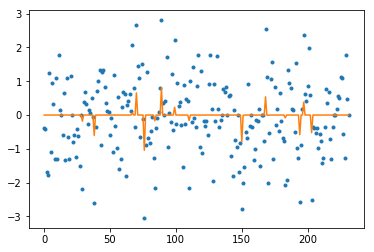

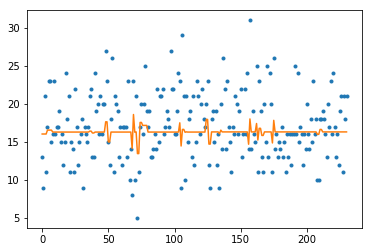

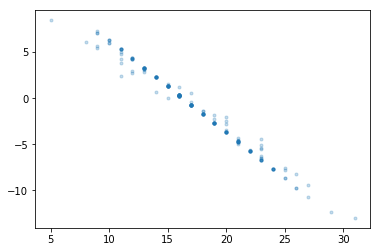

In [177]:
plt.plot(pywt.coeffs_to_array(poisson_wave)[0][2:],'.')
plt.plot(pywt.coeffs_to_array(poisson_wave_smoothed)[0][2:],'-')
plt.show()
plt.plot(poisson_counts,'.')
plt.plot(poisson_smoothed)
plt.show()
plt.plot(poisson_counts, poisson_smoothed-poisson_counts, '.', alpha=0.25)
plt.show()

In [178]:
poisson_counts = np.random.poisson(lam_med+5*np.sin(np.arange(4*np.pi*len(recomb_norm))/len(recomb_norm)))
poisson_ansc = anscombe_transform(poisson_counts)
poisson_wave = pywt.wavedec(poisson_ansc, wavelet, extension_mode)
poisson_wave_smoothed = denoise_wavelets(poisson_wave, t=2.0)
poisson_inv = pywt.waverec(poisson_wave_smoothed, wavelet, extension_mode)
if len(poisson_inv) > len(poisson_counts):
    poisson_inv = poisson_inv[:-(len(poisson_inv)-len(poisson_counts))]
poisson_smoothed = anscombe_transform_inverse(poisson_inv)

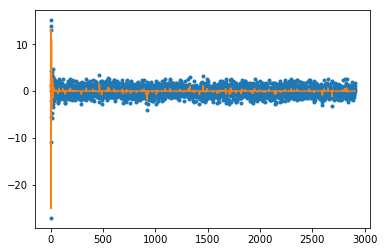

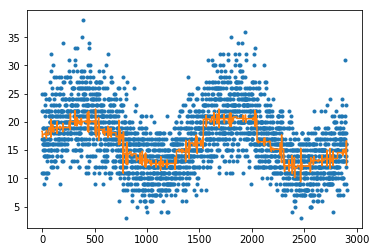

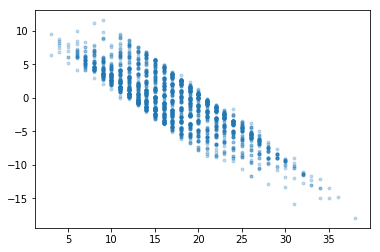

In [179]:
plt.plot(pywt.coeffs_to_array(poisson_wave)[0][2:],'.')
plt.plot(pywt.coeffs_to_array(poisson_wave_smoothed)[0][2:],'-')
plt.show()
plt.plot(poisson_counts,'.')
plt.plot(poisson_smoothed)
plt.show()
plt.plot(poisson_counts, poisson_smoothed-poisson_counts, '.', alpha=0.25)
plt.show()

In [181]:
poisson_wave = pywt.wavedec(poisson_counts, wavelet, extension_mode)
poisson_wave_smoothed = denoise_wavelets(poisson_wave, t=2*np.sqrt(17))
poisson_inv = pywt.waverec(poisson_wave_smoothed, wavelet, extension_mode)
if len(poisson_inv) > len(poisson_counts):
    poisson_inv = poisson_inv[:-(len(poisson_inv)-len(poisson_counts))]
poisson_smoothed = poisson_inv

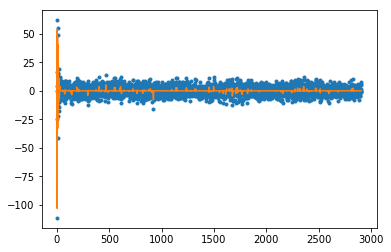

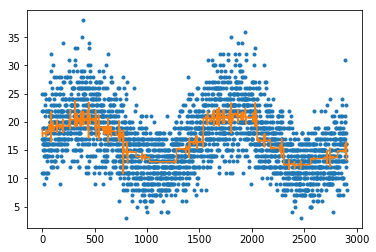

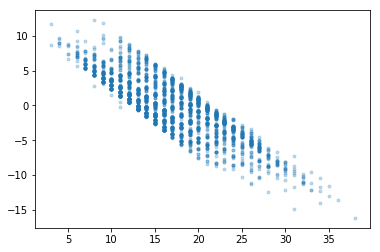

In [182]:
plt.plot(pywt.coeffs_to_array(poisson_wave)[0][2:],'.')
plt.plot(pywt.coeffs_to_array(poisson_wave_smoothed)[0][2:],'-')
plt.show()
plt.plot(poisson_counts,'.')
plt.plot(poisson_smoothed)
plt.show()
plt.plot(poisson_counts, poisson_smoothed-poisson_counts, '.', alpha=0.25)
plt.show()

In [183]:
poisson_counts = np.random.poisson(lam_med * (np.arange(len(recomb_norm))/len(recomb_norm))**3)
poisson_ansc = anscombe_transform(poisson_counts)
poisson_wave = pywt.wavedec(poisson_ansc, wavelet, extension_mode)
poisson_wave_smoothed = denoise_wavelets(poisson_wave, t=2.0)
poisson_inv = pywt.waverec(poisson_wave_smoothed, wavelet, extension_mode)
if len(poisson_inv) > len(poisson_counts):
    poisson_inv = poisson_inv[:-(len(poisson_inv)-len(poisson_counts))]
poisson_smoothed = anscombe_transform_inverse(poisson_inv)

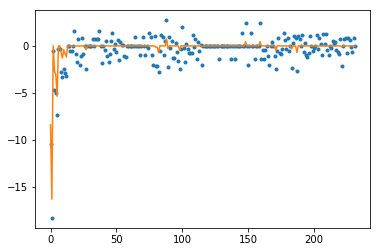

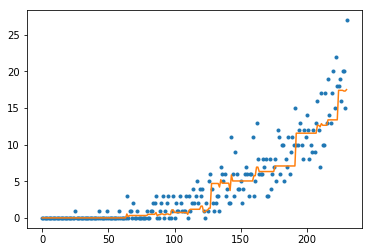

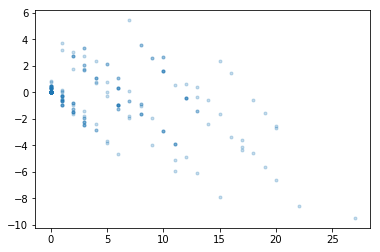

In [184]:
plt.plot(pywt.coeffs_to_array(poisson_wave)[0][2:],'.')
plt.plot(pywt.coeffs_to_array(poisson_wave_smoothed)[0][2:],'-')
plt.show()
plt.plot(poisson_counts,'.')
plt.plot(poisson_smoothed)
plt.show()
plt.plot(poisson_counts, poisson_smoothed-poisson_counts, '.', alpha=0.25)
plt.show()

In [185]:
poisson_wave = pywt.wavedec(poisson_counts, wavelet, extension_mode)
poisson_wave_smoothed = denoise_wavelets(poisson_wave, t=2*np.std(poisson_counts))
poisson_inv = pywt.waverec(poisson_wave_smoothed, wavelet, extension_mode)
if len(poisson_inv) > len(poisson_counts):
    poisson_inv = poisson_inv[:-(len(poisson_inv)-len(poisson_counts))]
poisson_smoothed = poisson_inv

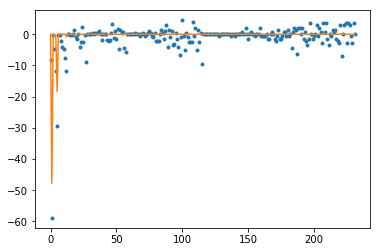

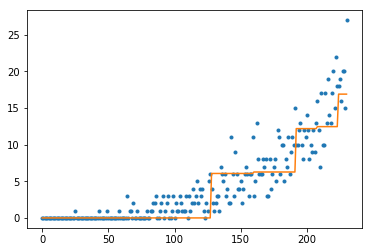

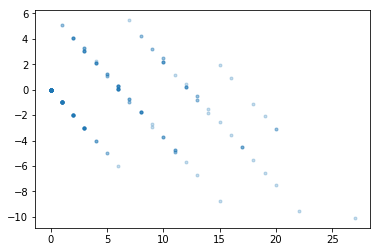

In [186]:
plt.plot(pywt.coeffs_to_array(poisson_wave)[0][2:],'.')
plt.plot(pywt.coeffs_to_array(poisson_wave_smoothed)[0][2:],'-')
plt.show()
plt.plot(poisson_counts,'.')
plt.plot(poisson_smoothed)
plt.show()
plt.plot(poisson_counts, poisson_smoothed-poisson_counts, '.', alpha=0.25)
plt.show()

# All chromosomes

In [152]:
chroms = ['chr2L', 'chr2R', 'chr3L', 'chr3R']
data = [np.loadtxt(data_dir + 'Comeron_100kb_{}.txt'.format(c)) for c in chroms]
locations = [d[:,0] for d in data]
recombs = [d[:,1] for d in data]

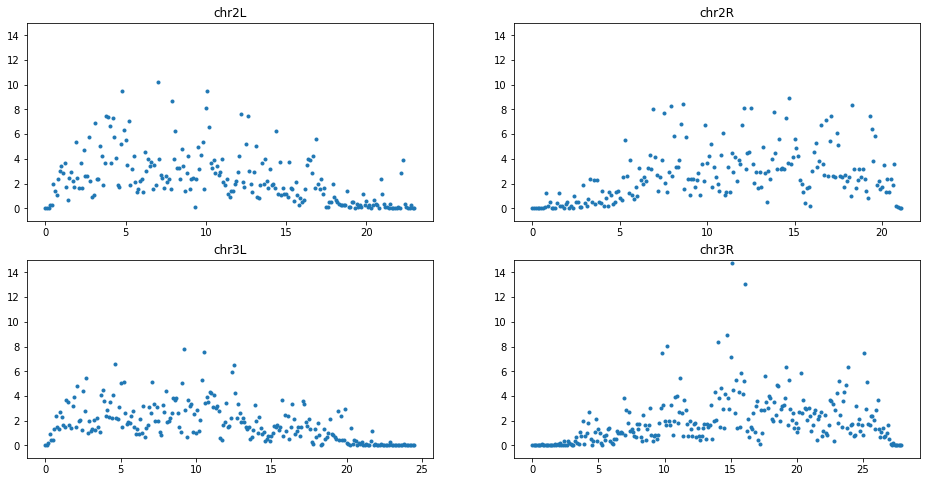

In [153]:
fig = plt.figure(figsize=(16,8))
for i in range(4):
    ax = plt.subplot(2,2,i+1)
    ax.plot(locations[i]/1e6, recombs[i], '.')
    ax.set_title(chroms[i])
    ax.set_ylim([-1,15])
#ax1.set_ylabel('Recombination rate (cM/Mb)')
#ax1.set_title(r'Recombination rate on D. mel. Chr2L')
plt.show()

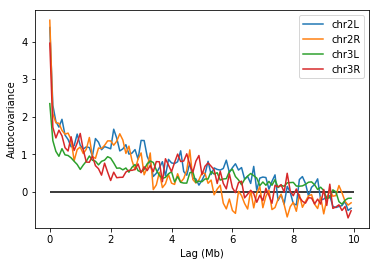

In [169]:
for i in range(4):
    D, ac = autocov(recombs[i], max_d)
    plt.plot(D*w_size/1e6,ac, '-', label=chroms[i])
plt.hlines(0, 0, 10)
plt.xlabel('Lag (Mb)')
plt.ylabel('Autocovariance')
plt.legend()
plt.show()

[ 0.11727507  0.10846418  0.06922586  0.10881414]


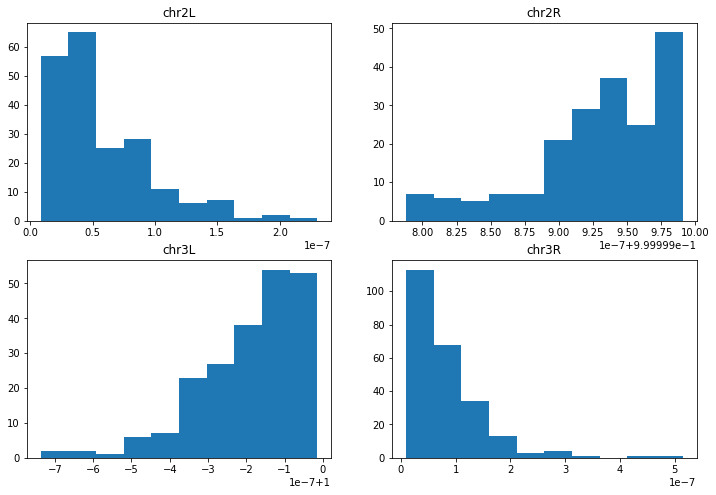

In [158]:
fig = plt.figure(figsize=(12,8))
min_rs = np.zeros(4)
recombs_norm = []
for i in range(4):
    r = recombs[i]
    min_rs[i] = min(r[r>0])
    rem, rn = np.modf(r / min_rs[i])
    rn = np.round(r/min_rs[i])
    ax = plt.subplot(2,2,i+1)
    ax.hist(rem[rem>0])
    ax.set_title(chroms[i])
    recombs_norm.append(rn)
print(min_rs)
plt.show()

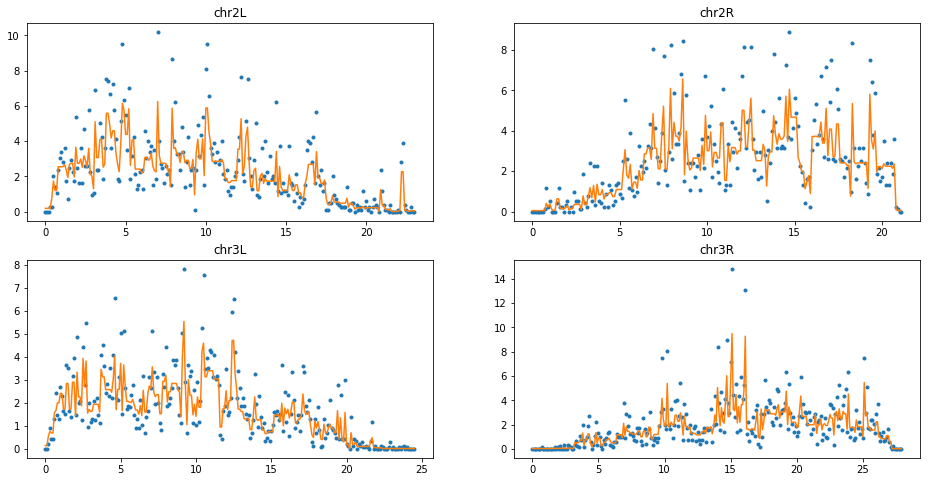

In [165]:
fig = plt.figure(figsize=(16,8))
recombs_smoothed = []
for i in range(4):
    ra = anscombe_transform(recombs_norm[i])
    wc = pywt.wavedec(ra, wavelet, extension_mode)
    wc_smoothed = denoise_wavelets(wc, t=threshold)
    inv = pywt.waverec(wc_smoothed, wavelet, extension_mode)
    if len(inv) > len(locations[i]):
        inv = inv[:-(len(inv)-len(locations[i]))]
    rs = anscombe_transform_inverse(inv) * min_rs[i]
    recombs_smoothed.append(rs)
    ax = plt.subplot(2,2,i+1)
    ax.plot(locations[i]/1e6, recombs[i], '.')
    ax.plot(locations[i]/1e6, rs, '-')
    ax.set_title(chroms[i])
    #ax.set_ylim([-1,15])
plt.show()

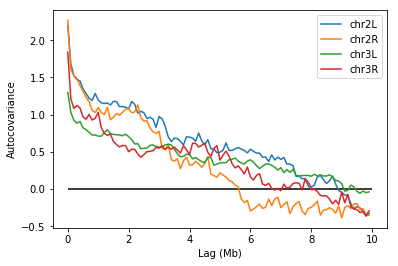

In [168]:
for i in range(4):
    D, ac = autocov(recombs_smoothed[i], max_d)
    plt.plot(D*w_size/1e6,ac, '-', label=chroms[i])
plt.hlines(0, 0, 10)
plt.xlabel('Lag (Mb)')
plt.ylabel('Autocovariance')
plt.legend()
plt.show()